### Setup

The cell below downloads the code from Github and install necessary dependencies.

In [1]:
# ![ -d deeprte] || git clone --depth=1 https://github.com/mazhengcn/deeprte.git
# !cd deeprte && git pull
# !pip install -qr deeprte/requirements.txt

### Import Packages

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

%load_ext autoreload
%autoreload 2

import jax.numpy as jnp
import numpy as np
import jax
import haiku as hk
import json
import ml_collections
from test import utils
from deeprte.model.modules import DeepRTE
from deeprte.model.tf.input_pipeline import load_tf_data
from deeprte.model.data import flat_params_to_haiku

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
jax.local_devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

### Import Pre-trained model

In [3]:
# Path to the model parameters
PARAMS_DIR = "/workspaces/deeprte/rte_data/model_params"
PARAMS_NAME = "params.npz"
CONFIG_NAME = "config.json"

config_path = os.path.join(PARAMS_DIR, CONFIG_NAME)
assert os.path.exists(f'{config_path}')

param_path = os.path.join(PARAMS_DIR, PARAMS_NAME)
assert os.path.exists(f'{param_path}')

In [4]:
# load and visualize the model config
with open(config_path) as f:
    str = f.read()
    config = json.loads(str)

config = ml_collections.ConfigDict(config["experiment_kwargs"]['config'])

config.model.green_function

attenuation:
  attention:
    key_chunk_size: 128
    key_dim: 32
    num_head: 2
    output_dim: 2
    value_dim: null
  latent_dim: 128
  num_layer: 4
  output_dim: 16
scattering:
  latent_dim: 16
  num_layer: 2

In [5]:
# Load the model parameters
np_params = np.load(param_path)
params = flat_params_to_haiku(np_params)

In [6]:
# set up the model and transform it into a jax function
def forward_fn(batch):
    out = DeepRTE(config.model)(batch, is_training=False, compute_loss=False, compute_metrics=False)
    return out

forward = hk.transform(forward_fn)
apply = jax.jit(forward.apply)

### Load dataset

In [7]:
# Path to the dataset
DATA_DIR = "/workspaces/deeprte/rte_data/matlab/train-scattering-kernel-0309/"
DATA_NAME = "train_random_kernel_2.mat"

# slice batch by index
idx = 0

data_path = os.path.join(DATA_DIR, DATA_NAME)
assert os.path.exists(f'{data_path}')

In [8]:
# load and slice batch by index
tf_data = load_tf_data(DATA_DIR, [DATA_NAME,], normalization=False)
features = jax.tree_map(lambda x: jnp.array(x), tf_data)
data_feature = features[0]
batch = utils.slice_batch(idx, data_feature)

# visualize shape
jax.tree_util.tree_map(lambda x: x.shape, batch)

{'boundary': (1, 1920),
 'boundary_coords': (1920, 4),
 'boundary_scattering_kernel': (1, 1920, 24),
 'boundary_weights': (1920,),
 'phase_coords': (38400, 4),
 'position_coords': (1600, 2),
 'psi_label': (1, 38400),
 'scattering_kernel': (1, 38400, 24),
 'self_scattering_kernel': (1, 24, 24),
 'sigma': (1, 1600, 2),
 'velocity_coords': (24, 2),
 'velocity_weights': (24,)}

### Evaluate

In [9]:
# set rng seed
rng = hk.PRNGSequence(42)

In [10]:
# get psi shape
psi_shape = utils.get_psi_shape(DATA_DIR, [DATA_NAME,])
normalize_rate = utils.get_normalized_rate(config)

# get ret, which contains the predicted solution phi, psi.
def get_ret(batch):
    ret = apply(params, next(rng), batch)
    psi = ret["predicted_solution"]
    psi = psi*normalize_rate

    dict = {}
    dict["psi_pre"] = psi.reshape(*psi_shape)
    dict["psi_label"] = batch["psi_label"].reshape(*psi_shape)
    dict["phi_pre"] = jnp.dot(dict["psi_pre"], batch["velocity_weights"])
    dict["phi_label"] = jnp.dot(dict["psi_label"], batch["velocity_weights"])

    return dict
# print rmse
def print_rmse(dict):
    print("phi rmse:",jnp.sqrt(jnp.mean((dict["phi_label"] - dict["phi_pre"])**2)/jnp.mean(dict["phi_pre"]**2)), "psi rmse:", jnp.sqrt(jnp.mean((dict["psi_label"] - dict["psi_pre"])**2)/jnp.mean(dict["psi_pre"]**2)))

In [11]:
# evaluate and print rmse

ret = get_ret(batch)
print_rmse(ret)

phi rmse: 0.028916763 psi rmse: 0.055958178


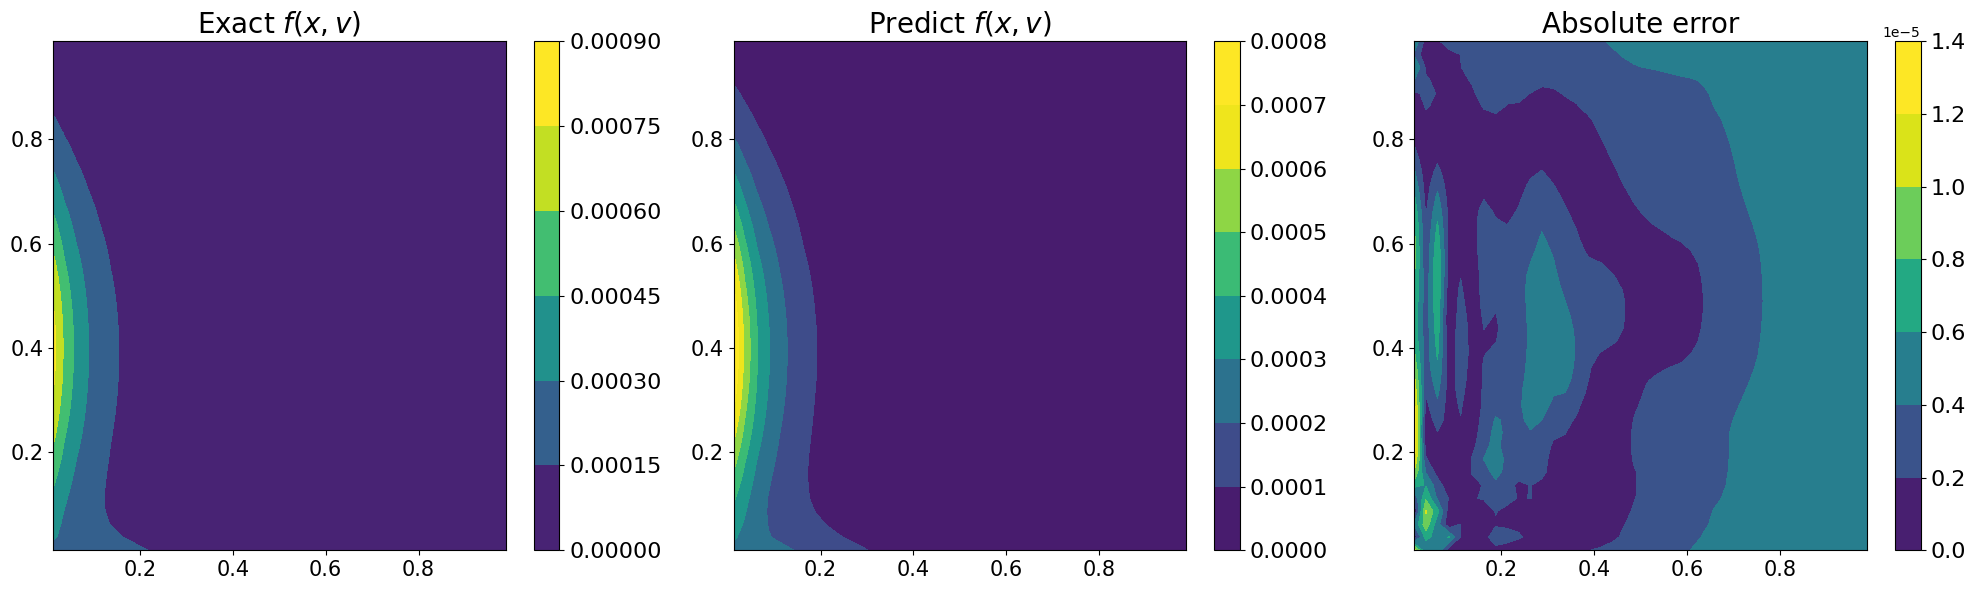

rmse: 0.028686775


In [12]:
# plot phi and absolute error

r = batch['position_coords'].reshape(*psi_shape[:-1], 2)
utils.plot_phi(r, ret["phi_label"], ret["phi_pre"])